# Options pricing via Fourier Transform

Valuation of European Call Options in BSM Model
Comparison of Analytical, int_valueegral and FFT Approach

Reference: Dr. Yves J. Hilpisch, "Derivatives Analytics with Python"

In [1]:
# Standard python packages
import math
from time import time

# Third party packages
import numpy as np
import matplotlib.pyplot as plt

# Local packages
from options.models.bsm import BSM
from options.models.bsm_fourier import BSM_FT_NUM
from options.models.bsm_fourier import BSM_FFT

In [2]:
# Model parameters

S0 = 100.00     # Current stock price
K = 100.00      # Option strike price
T = 1           # Option expiry time 
r = 0.05        # Risk-free rate
sigma = 0.2     # IV
lamb = 1        # Jump frequency
mu = -0.1       # Expected jump size
delta = 0.1     # Jump size volatility

## Comparison between Lewis method and BSM analytical formula

Valuation accuracy of Lewis’ integral approach in comparison to BSM analytical formula; parameter values are S0 = 100, T = 1.0, r = 0.05, 𝜎 = 0.2

In [3]:
def plot_val_differences_bsm(vtype='int'):
    k_list = np.linspace(S0 * 0.6, S0 * 1.4, 50)
    ana_values = BSM().price('call', S0, k_list, T, r, sigma)
    plt.figure(figsize=(8, 6))
    plt.subplot(311)
    plt.plot(k_list, ana_values, 'b', label='analytical', lw=1.5)
    if vtype == 'int':
        int_values = np.array([BSM_FT_NUM().price('call', S0, K, T, r, sigma)
                               for K in k_list])
        plt.plot(k_list, int_values, 'r-.', label='Fourier (integral)', lw=1.5)
        diffs = int_values - ana_values
        rdiffs = (int_values - ana_values) / ana_values
    elif vtype == 'fft':
        fft_values = np.array([BSM_FFT().price('call', S0, K, T, r, sigma)
                               for K in k_list])
        plt.plot(k_list, fft_values, 'r-.', label='Fourier (FFT)', lw=1.5)
        diffs = fft_values - ana_values
        rdiffs = (fft_values - ana_values) / ana_values
    plt.legend()
    plt.grid()
    plt.subplot(312)
    plt.plot(k_list, diffs, 'g', label='abs. difference', lw=1.5)
    plt.legend(loc=0)
    plt.grid()
    plt.subplot(313)
    plt.plot(k_list, rdiffs, 'r', label='rel. difference', lw=1.5)
    plt.legend(loc=0)
    plt.xlabel('strike')
    plt.grid()
    plt.tight_layout()
    

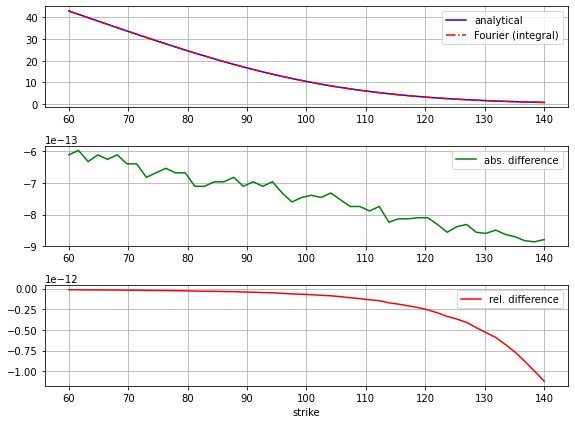

In [4]:
plot_val_differences_bsm(vtype='int')

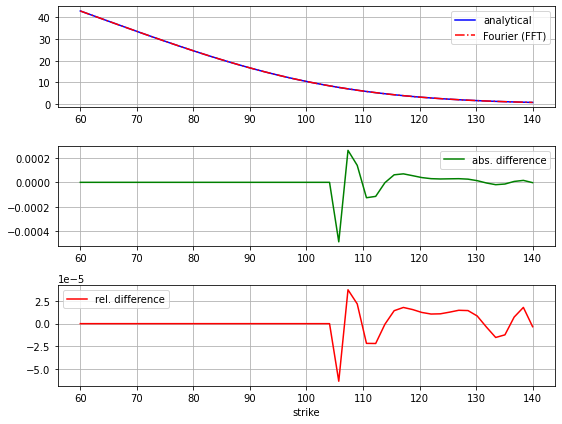

In [5]:
plot_val_differences_bsm(vtype='fft')

## Option Pricing with DFT/FFT Speed Test

Pricing using Fast Fourier Transform Algorithm on Binomial model

In [6]:
def get_binomial_parameters(M=100):
    # Time Parameters
    dt = T / M              # Length of time interval
    df = math.exp(-r * dt)  # Discount per interval

    # Binomial Parameters
    u = math.exp(sigma * math.sqrt(dt))     # Up movement
    d = 1 / u                               # Down movement
    q = (math.exp(r * dt) - d) / (u - d)    # Risk neutral probability
    return dt, df, u, d, q

In [7]:
def call_fft_value(M):
    from numpy.fft import fft, ifft

    # Parmeter Adjustments
    dt, df, u, d, q = get_binomial_parameters(M)

    # Array Generation for Stock Prices
    mu = np.arange(M + 1)
    mu = np.resize(mu, (M + 1, M + 1))
    md = np.transpose(mu)
    mu = u ** (mu - md)
    md = d ** md
    S = S0 * mu * md

    # Valuation by FFT
    CT = np.maximum(S[:, -1] - K, 0)        
    qv = np.zeros(M + 1, dtype=float)
    qv[0] = q
    qv[1] = 1 - q
    option_price = fft(math.exp(-r * T) * ifft(CT) * fft(qv) ** M)

    return option_price

In [8]:
start = time()
call_fft_value(1000)
elapsed_time = np.round(time() - start, 2)
print(f"Elapsed time for 1000 steps: {elapsed_time}s")

Elapsed time for 1000 steps: 0.02s


In [9]:
start = time()
call_fft_value(5000)
elapsed_time = np.round(time() - start, 2)
print(f"Elapsed time for 5000 steps: {elapsed_time}s")

Elapsed time for 5000 steps: 0.71s


In [10]:
start = time()
call_fft_value(10000)
elapsed_time = np.round(time() - start, 2)
print(f"Elapsed time for 10000 steps: {elapsed_time}s")

Elapsed time for 10000 steps: 2.97s
